# Project of Data Streaming 2020-2021

Authors: Maxime Millavet and Charles De Trogoff

This notebook was written for the project of Data Streaming (Master IASD Dauphine). The data is coming from a Kafka streaming flow. This flow contains clicks and displays of web advertisements by UserId.

The ***CTR or Click through rate*** is the number of clicks on an ad out of the total number of times that ad appears on the screens. In other words, if an ad appears 100 times and 5 people click on it, the CTR will be 5%.

The project aims to create a real-time Flink alert while reading the Kafka streaming flow, that returns fraudulent behaviour. 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime

## Overview

In [2]:
df = pd.read_csv('static.csv')
df.head()

,eventType,uid,timestamp,ip,impressionId
0,display,85ea1d35-54a1-477c-b601-bf21544aeeca,1621950258,63.141.167.230,7412d111-97aa-42eb-bd06-6f6eb4446709
1,display,0b5ec931-1aa7-4f1f-9774-77fa67bb4a3f,1621950258,210.172.236.147,927b8539-8a42-4341-85b7-1697003bd0e9
2,display,e754baf9-d3a7-4607-9be8-a7bbed686119,1621950258,98.149.42.161,a8467b0d-5ce7-42ad-a94b-c7a7f5bd1b39
3,display,7257ed9b-3334-4add-8172-c2e2b2d060d1,1621950258,163.213.252.67,913c2bfb-723a-46e1-9c52-2531aea4eba2
4,display,0e9b7333-7545-44fc-82fb-890246fb7737,1621950258,118.77.33.188,c606a0d0-0bc1-4339-8a23-7db12874ace9


In [3]:
print('{} events'.format(len(df)))

124692 events


In [4]:
print("The data is going from", datetime.fromtimestamp(min(df.timestamp)) , "to", datetime.fromtimestamp(max(df.timestamp)))

The data is going from 2021-05-25 15:44:18 to 2021-05-25 17:34:41


In [5]:
print('{} UIDs, {} IPs, {} impressionIDs'.format(
    len(df.uid.unique()),
    len(df.ip.unique()),
    len(df.impressionId.unique())
))

48795 UIDs, 10001 IPs, 94679 impressionIDs


### Mean of CTR per UID

In [6]:
df1 = df.loc[df["eventType"]=="display",:].groupby(["uid"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "display"}).reset_index()
df2 = df.loc[df["eventType"]=="click",:].groupby(["uid"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "click"}).reset_index()
total_df = df1.merge(df2, on='uid', how='inner')
total_clean_df = total_df.loc[total_df.display != 0, :]

total_clean_df['ratio'] = 0
total_clean_df.ratio = total_clean_df.click / total_clean_df.display

print(total_clean_df.ratio.mean(axis=0))
total_clean_df.head()

0.9808881670119142


,uid,display,click,ratio
0,00028e31-7207-4fa0-a392-88eebdee8e3510,1,1,1.0
1,0006bbfe-f74a-4f53-9d0f-5488c9e9db73,1,1,1.0
2,0008a6a0-c885-49a1-a4dd-19eac23a0728,1,1,1.0
3,0009b530-a37f-4681-9b6b-09e4cdd9c85818,1,1,1.0
4,000a2805-3ec5-453a-8e9e-0c32c6b8366e,1,1,1.0


In [7]:
df1 = df.loc[df["eventType"]=="display",:].groupby(["ip"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "display"}).reset_index()
df2 = df.loc[df["eventType"]=="click",:].groupby(["ip"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "click"}).reset_index()
total_df = df1.merge(df2, on='ip', how='inner')
total_clean_df = total_df.loc[total_df.display != 0, :]

total_clean_df['ratio'] = 0
total_clean_df.ratio = total_clean_df.click / total_clean_df.display

print(total_clean_df.ratio.mean(axis=0))
total_clean_df.head()

0.29706885715670944


,ip,display,click,ratio
0,0.1.221.174,11,1,0.090909
1,0.12.113.132,9,1,0.111111
2,0.120.186.242,7,2,0.285714
3,0.121.92.145,9,1,0.111111
4,0.123.142.254,13,5,0.384615


***Conclusion***: If we group by user ID, we notice that almost each userId seems to click everytime there is a clickable display (almost 100% of CTR). On the opposite, if we group by IP address, we find 30%. Our hypothesis is that some IP generates fake user IDs so that these user IDs cliks on each display. 

In [8]:
df1 = df.groupby(["uid","eventType"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "display"}).reset_index()
df.groupby(["uid","eventType"]).head()

,eventType,uid,timestamp,ip,impressionId
0,display,85ea1d35-54a1-477c-b601-bf21544aeeca,1621950258,63.141.167.230,7412d111-97aa-42eb-bd06-6f6eb4446709
1,display,0b5ec931-1aa7-4f1f-9774-77fa67bb4a3f,1621950258,210.172.236.147,927b8539-8a42-4341-85b7-1697003bd0e9
2,display,e754baf9-d3a7-4607-9be8-a7bbed686119,1621950258,98.149.42.161,a8467b0d-5ce7-42ad-a94b-c7a7f5bd1b39
3,display,7257ed9b-3334-4add-8172-c2e2b2d060d1,1621950258,163.213.252.67,913c2bfb-723a-46e1-9c52-2531aea4eba2
4,display,0e9b7333-7545-44fc-82fb-890246fb7737,1621950258,118.77.33.188,c606a0d0-0bc1-4339-8a23-7db12874ace9
...,...,...,...,...,...
124681,display,a85bef69-b9f2-420e-b472-11cd68bf2f13,1621956881,251.157.235.72,42e20a29-2545-426e-b179-7cace5e4255c
124684,display,64780b6d-34a7-4ac9-86b1-79f53e826eae,1621956881,105.129.117.250,15ddfbdd-caf4-4cdb-a81a-d2a31acaebf7
124687,display,f99b8789-0856-43ac-8465-6f1387982a18,1621956881,199.30.195.201,0d61ce48-f04d-43a6-b93c-fa3c5bd07b21
124688,click,e4a8620f-88fd-4e96-8c1c-c2c610c9008b,1621956881,87.82.84.251,1b20d635-2f12-4fd9-ac89-70753ce234f9


### Global clicks on total displays ratio 

In [9]:
CTR = df.groupby(["eventType"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "eventType_count"}).reset_index()
print("Global CTR is", round((CTR.iloc[0]['eventType_count']/CTR.iloc[1]['eventType_count'])*100,2), "%")

CTR.head()

Global CTR is 31.89 %


,eventType,eventType_count
0,click,30150
1,display,94542


We are using below libraries to explore the data (the profile report describes a dataframe throught an html dashboard)

## Identify fraudulent events

### IPs that clicks a lot

,ip,click_count
0,238.186.83.58,6630
1,206.218.212.93,10
2,16.7.14.204,9
3,7.45.3.132,9
4,178.192.51.223,9


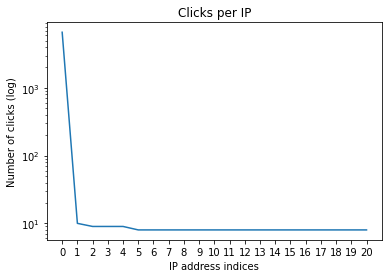

In [112]:
df2 = df.loc[df.eventType == 'click',:].groupby(["ip"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "click_count"}).sort_values(by=['click_count'], ascending=False).reset_index()
df2_limited = df2.loc[0:20,:]

X = df2_limited.to_numpy()
X_ind = np.concatenate(
    (np.arange(len(df2_limited)).reshape(-1,1),X),
    axis=1
)
plt.semilogy(X_ind[:,0], X_ind[:,2])
plt.xlabel('IP address indices')
plt.xticks(range(len(df2_limited)))
plt.ylabel('Number of clicks (log)')
plt.title('Clicks per IP')

df2_limited.head()

### Investigation on IP : how many UIDs per IP ?

,ip,uid_count
0,238.186.83.58,13260
1,124.34.56.145,28
2,241.16.82.53,27
3,206.218.212.93,26
4,82.23.146.70,26


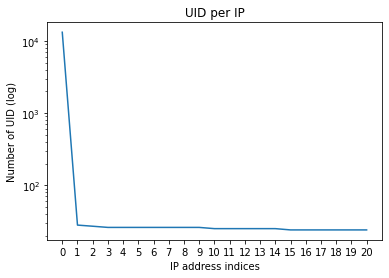

In [113]:
df_uid_per_ip = df.groupby(["ip"]).agg({'uid' : 'count'}).rename(columns={'uid': "uid_count"}).sort_values(by=['uid_count'], ascending=False).reset_index()

df_uid_per_ip_limited = df_uid_per_ip.loc[0:20,:]

X_uid_per_ip = df_uid_per_ip_limited.uid_count.to_numpy()
X_ind = np.arange(X_uid_per_ip.shape[0])

plt.semilogy(X_ind, X_uid_per_ip)
plt.xlabel('IP address indices')
plt.xticks(range(X_ind.shape[0]))
plt.ylabel('Number of UID (log)')
plt.title('UID per IP')

df_uid_per_ip.head()

### Investigation on UID : number of clicks and displays

,uid,click_count
0,d2617b04-ffcf-48dc-be7c-90e240a5a469,444
1,242a173c-072a-4e0c-b05c-89aa15dde44a,438
2,9786bdb8-23a4-4807-b495-903ecb1d2eb9,431
3,d459c28e-72fb-48f3-9a34-88135861b88e,424
4,09e07e83-bc50-4051-835c-6a5f97c339fb,418


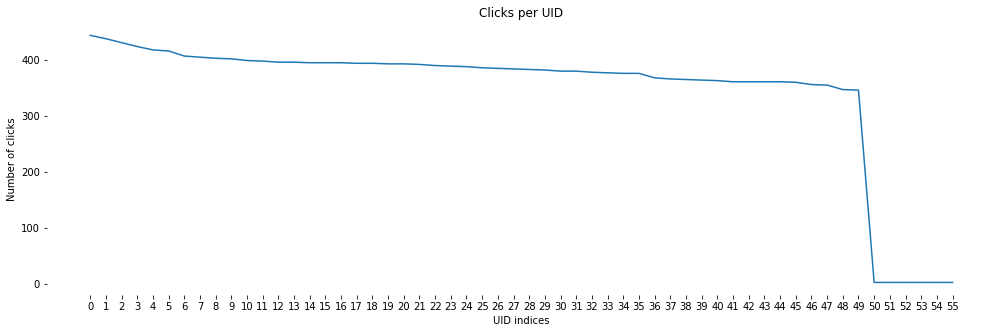

In [115]:
df2 = df.loc[df.eventType == 'click',:].groupby(["uid"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "click_count"}).sort_values(by=['click_count'], ascending=False).reset_index()
df2_limited = df2.loc[0:55,:]


max_ = df2.click_count.max()

X = df2_limited.to_numpy()
X_ind = np.concatenate(
    (np.arange(len(df2_limited)).reshape(-1,1),X),
    axis=1
)
plt.figure(figsize=(17,5))
plt.plot(X_ind[:,0], X_ind[:,2])
plt.xlabel('UID indices')
plt.xticks(range(len(df2_limited)))
plt.ylabel('Number of clicks')
plt.title('Clicks per UID')
plt.box(False)

df2_limited.head()

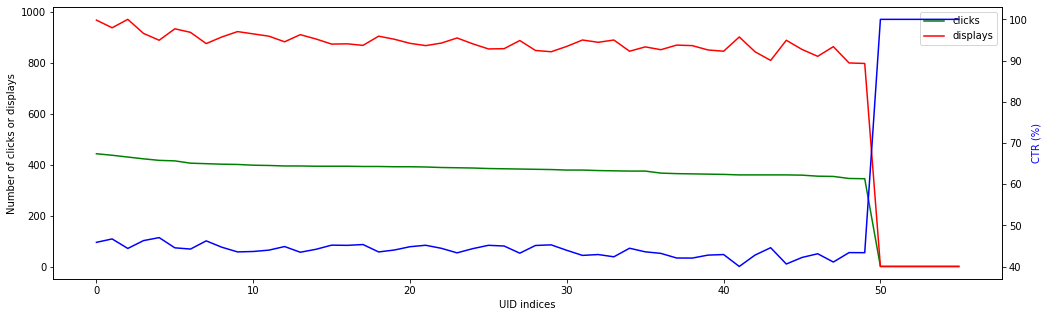

In [130]:
df_click = df.loc[df.eventType == 'click' and ,:].groupby(["uid"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "click_count"}).sort_values(by=['click_count'], ascending=False).reset_index()
df_click_limited = df_click.loc[0:55,:]

df_display = df.loc[df.eventType == 'display',:].groupby(["uid"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "display_count"}).reset_index()

df_merged = df_click_limited.merge(df_display, on='uid', how='inner')
df_merged['CTR'] = None
df_merged.CTR = round(df_merged.click_count / df_merged.display_count * 100, 2)


X_clicks = df_merged.click_count.to_numpy().reshape(-1,1)
X_displays = df_merged.display_count.to_numpy().reshape(-1,1)
X_CTR = df_merged.CTR.to_numpy().reshape(-1,1)
X_clicks_ind = np.arange(X_clicks.shape[0]).reshape(-1,1)


fig, ax1 = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(17)

ax2 = ax1.twinx()
ax1.plot(X_clicks_ind, X_clicks, 'g-')
ax1.plot(X_clicks_ind, X_displays, 'r-')
ax2.plot(X_clicks_ind, X_CTR, 'b-')

ax1.set_xlabel('UID indices')
ax1.set_ylabel('Number of clicks or displays')
ax2.set_ylabel('CTR (%)', color='b')

ax1.legend(['clicks', 'displays'])

plt.show()

,uid,click_count,display_count,CTR
0,d2617b04-ffcf-48dc-be7c-90e240a5a469,444,968,45.87
1,242a173c-072a-4e0c-b05c-89aa15dde44a,438,938,46.70
2,9786bdb8-23a4-4807-b495-903ecb1d2eb9,431,971,44.39
3,d459c28e-72fb-48f3-9a34-88135861b88e,424,916,46.29
4,09e07e83-bc50-4051-835c-6a5f97c339fb,418,889,47.02


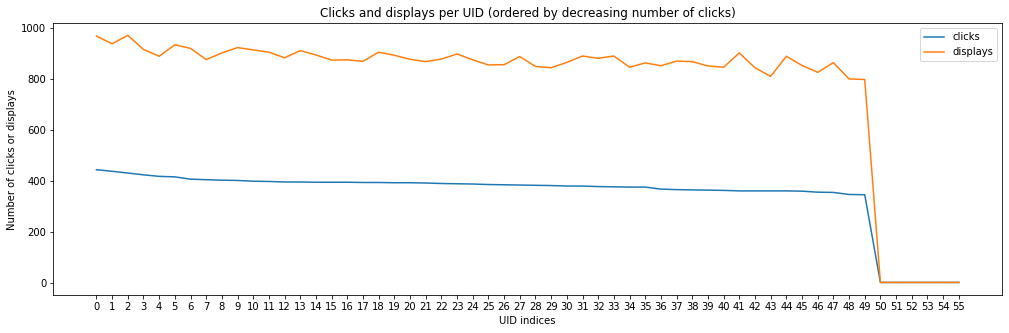

In [132]:
df_click = df.loc[df.eventType == 'click',:].groupby(["uid"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "click_count"}).sort_values(by=['click_count'], ascending=False).reset_index()
df_click_limited = df_click.loc[0:55,:]

df_display = df.loc[df.eventType == 'display',:].groupby(["uid"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "display_count"}).reset_index()

df_merged = df_click_limited.merge(df_display, on='uid', how='inner')
df_merged['CTR'] = None
df_merged.CTR = round(df_merged.click_count / df_merged.display_count * 100, 2)


X_clicks = df_merged.click_count.to_numpy().reshape(-1,1)
X_displays = df_merged.display_count.to_numpy().reshape(-1,1)
X_CTR = df_merged.CTR.to_numpy().reshape(-1,1)
X_clicks_ind = np.arange(X_clicks.shape[0]).reshape(-1,1)


plt.figure(figsize=(17,5))
plt.plot(X_clicks_ind, X_clicks, label='clicks')
plt.plot(X_clicks_ind, X_displays, label='displays')
plt.xlabel('UID indices')
plt.xticks(range(X_clicks_ind.shape[0]))
plt.ylabel('Number of clicks or displays')
plt.title('Clicks and displays per UID (ordered by decreasing number of clicks)')
plt.legend()

df_merged.head()
